In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os

import bokeh        
from bokeh.io import show, output_notebook, push_notebook
from bokeh.layouts import row, column, widgetbox
from bokeh.plotting import figure
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
from bokeh.models import BoxAnnotation
from bokeh.models.widgets import Div
from bokeh.models.glyphs import Text

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [2]:
def create_football_field(linenumbers=True, endzones=True, highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                         figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1, edgecolor='r', facecolor='darkgreen', zorder=0)
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20, # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20, # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        ticks_range = range(11, 110)
    else:
        ticks_range = range(1, 120)

    for x in ticks_range:
        plt.plot([x, x], [0, 1], color='white')
        plt.plot([x, x], [53.3, 52.3], color='white')
        plt.plot([x, x], [18.5, 19.5], color='white')
        plt.plot([x, x], [34.8, 35.8], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    
    return fig, ax
    

In [3]:
# Read in non-NGS data sources
ppd = pd.read_csv('../input/player_punt_data.csv')
gd = pd.read_csv('../input/game_data.csv')
pprd = pd.read_csv('../input/play_player_role_data.csv')
vr = pd.read_csv('../input/video_review.csv')
vfi = pd.read_csv('../input/video_footage-injury.csv')
pi = pd.read_csv('../input/play_information.csv')
vfi = vfi.rename(columns={'season' : 'season_year'})
all_dfs = [ppd, gd, pprd, vr, vfi, pi]
for mydf in all_dfs:
    mydf.columns = [col.lower() for col in mydf.columns]

In [4]:
# Detailed role info
role_info_dict = {'GL': ['Gunner', 'Punting_Team'],
             'GLi': ['Gunner', 'Punting_Team'],
             'GLo': ['Gunner', 'Punting_Team'],
             'GR': ['Gunner', 'Punting_Team'],
             'GRi': ['Gunner', 'Punting_Team'],
             'GRo': ['Gunner', 'Punting_Team'],
             'P': ['Punter', 'Punting_Team'],
             'PC': ['Punter_Protector', 'Punting_Team'],
             'PPR': ['Punter_Protector', 'Punting_Team'],
             'PPRi': ['Punter_Protector', 'Punting_Team'],
             'PPRo': ['Punter_Protector', 'Punting_Team'],
             'PDL1': ['Defensive_Lineman', 'Returning_Team'],
             'PDL2': ['Defensive_Lineman', 'Returning_Team'],
             'PDL3': ['Defensive_Lineman', 'Returning_Team'],
             'PDR1': ['Defensive_Lineman', 'Returning_Team'],
             'PDR2': ['Defensive_Lineman', 'Returning_Team'],
             'PDR3': ['Defensive_Lineman', 'Returning_Team'],
             'PDL5': ['Defensive_Lineman', 'Returning_Team'],
             'PDL6': ['Defensive_Lineman', 'Returning_Team'],
             'PFB': ['PuntFullBack', 'Punting_Team'],
             'PLG': ['Punting_Lineman', 'Punting_Team'],
             'PLL': ['Defensive_Backer', 'Returning_Team'],
             'PLL1': ['Defensive_Backer', 'Returning_Team'],
             'PLL3': ['Defensive_Backer', 'Returning_Team'],
             'PLS': ['Punting_Longsnapper', 'Punting_Team'],
             'PLT': ['Punting_Lineman', 'Punting_Team'],
             'PLW': ['Punting_Wing', 'Punting_Team'],
             'PRW': ['Punting_Wing', 'Punting_Team'],
             'PR': ['Punt_Returner', 'Returning_Team'],
             'PRG': ['Punting_Lineman', 'Punting_Team'],
             'PRT': ['Punting_Lineman', 'Punting_Team'],
             'VLo': ['Jammer', 'Returning_Team'],
             'VR': ['Jammer', 'Returning_Team'],
             'VL': ['Jammer', 'Returning_Team'],
             'VRo': ['Jammer', 'Returning_Team'],
             'VRi': ['Jammer', 'Returning_Team'],
             'VLi': ['Jammer', 'Returning_Team'],
             'PPL': ['Punter_Protector', 'Punting_Team'],
             'PPLo': ['Punter_Protector', 'Punting_Team'],
             'PPLi': ['Punter_Protector', 'Punting_Team'],
             'PLR': ['Defensive_Backer', 'Returning_Team'],
             'PRRo': ['Defensive_Backer', 'Returning_Team'],
             'PDL4': ['Defensive_Lineman', 'Returning_Team'],
             'PDR4': ['Defensive_Lineman', 'Returning_Team'],
             'PLM': ['Defensive_Backer', 'Returning_Team'],
             'PLM1': ['Defensive_Backer', 'Returning_Team'],
             'PLR1': ['Defensive_Backer', 'Returning_Team'],
             'PLR2': ['Defensive_Backer', 'Returning_Team'],
             'PLR3': ['Defensive_Backer', 'Returning_Team'],
             'PLL2': ['Defensive_Backer', 'Returning_Team'],
             'PDM': ['Defensive_Lineman', 'Returning_Team'],
             'PDR5': ['Defensive_Lineman', 'Returning_Team'],
             'PDR6': ['Defensive_Lineman', 'Returning_Team'],
             }
role_info = pd.DataFrame.from_dict(role_info_dict, orient='index', columns=['generalized_role','punting_returning_team']).reset_index().rename(columns={'index' : 'role'})
#ngs = pd.merge(ngs, role_info, how='left')

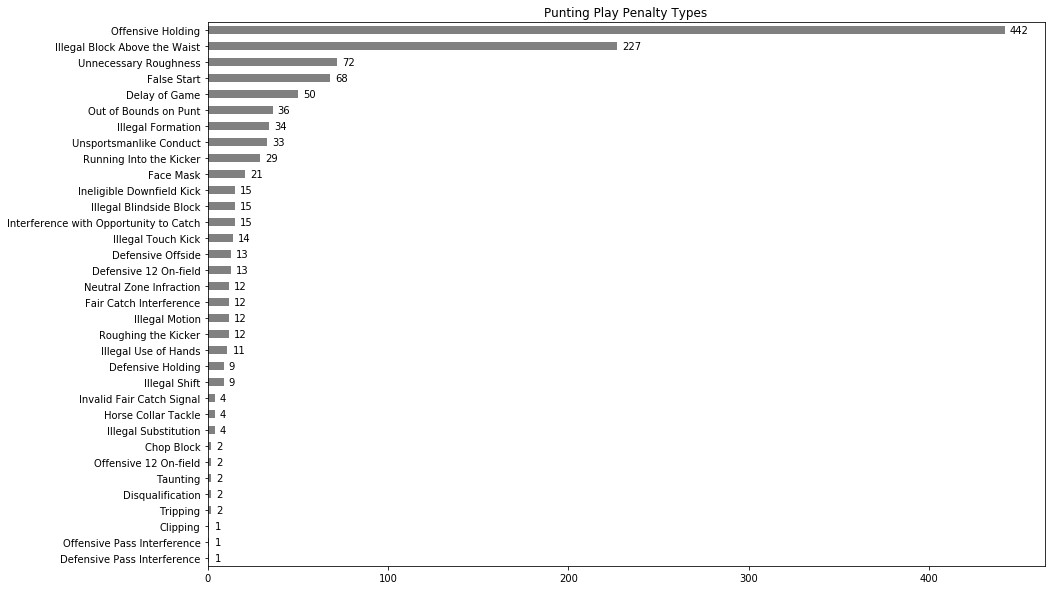

In [5]:
# Penalties

penalties_list = ['Offensive Holding', 'Defensive 12 On-field', 'Illegal Block Above the Waist', 'Fair Catch Interference',
                  'Running Into the Kicker', 'Unnecessary Roughness', 'Illegal Touch Kick',
                  'Illegal Use of Hands', 'False Start', 'Out of Bounds on Punt', 'Horse Collar Tackle',
                  'Face Mask', 'Ineligible Downfield Kick', 'Illegal Substitution', 'Illegal Formation',
                  'Delay of Game', 'Illegal Blindside Block', 'Neutral Zone Infraction', 'Tripping',
                  'Defensive Holding', 'Roughing the Kicker', 'Unsportsmanlike Conduct', 'Defensive Offside',
                  'Interference with Opportunity to Catch', 'Illegal Motion', 'Chop Block', 'Clipping',
                  'Invalid Fair Catch Signal', 'Illegal Shift', 'Offensive 12 On-field', 'Taunting',
                  'Offensive Pass Interference', 'Disqualification', 'Defensive Pass Interference']

pi['PENALTY'] = (pi['playdescription'].str.contains('PENALTY') | pi['playdescription'].str.contains('Penalty'))
pi['declined'] = pi['playdescription'].str.contains('declined')


pi['Offensive Holding'] =  pi['playdescription'].str.contains('Offensive Holding')
pi['Defensive 12 On-field'] =  pi['playdescription'].str.contains('Defensive 12 On-field')
pi['Illegal Block Above the Waist'] =  pi['playdescription'].str.contains('Illegal Block Above the Waist')
pi['Fair Catch Interference'] = pi['playdescription'].str.contains('Fair Catch Interference')
pi['Running Into the Kicker'] = pi['playdescription'].str.contains('Running Into the Kicker')
pi['Unnecessary Roughness'] = pi['playdescription'].str.contains('Unnecessary Roughness')
pi['Illegal Touch Kick'] = pi['playdescription'].str.contains('Illegal Touch Kick')
pi['Illegal Use of Hands'] = pi['playdescription'].str.contains('Illegal Use of Hands')
pi['False Start'] = pi['playdescription'].str.contains('False Start')
pi['Out of Bounds on Punt'] = pi['playdescription'].str.contains('Out of Bounds on Punt')
pi['Horse Collar Tackle'] = pi['playdescription'].str.contains('Horse Collar Tackle')
pi['Face Mask'] = pi['playdescription'].str.contains('Face Mask')
pi['Ineligible Downfield Kick'] = pi['playdescription'].str.contains('Ineligible Downfield Kick')
pi['Illegal Substitution'] = pi['playdescription'].str.contains('Illegal Substitution')
pi['Illegal Formation'] = pi['playdescription'].str.contains('Illegal Formation')
pi['Delay of Game'] = pi['playdescription'].str.contains('Delay of Game')
pi['Illegal Blindside Block'] = pi['playdescription'].str.contains('Illegal Blindside Block')
pi['Neutral Zone Infraction'] = pi['playdescription'].str.contains('Neutral Zone Infraction')
pi['Tripping'] = pi['playdescription'].str.contains('Tripping')
pi['Defensive Holding'] = pi['playdescription'].str.contains('Defensive Holding')
pi['Roughing the Kicker'] = pi['playdescription'].str.contains('Roughing the Kicker')
pi['Unsportsmanlike Conduct'] = pi['playdescription'].str.contains('Unsportsmanlike Conduct')
pi['Defensive Offside'] = pi['playdescription'].str.contains('Defensive Offside')
pi['Interference with Opportunity to Catch'] = pi['playdescription'].str.contains('Interference with Opportunity to Catch')
pi['Illegal Motion'] = pi['playdescription'].str.contains('Illegal Motion')
pi['Chop Block'] = pi['playdescription'].str.contains('Chop Block')
pi['Clipping'] = pi['playdescription'].str.contains('Clipping')
pi['Invalid Fair Catch Signal'] = pi['playdescription'].str.contains('Invalid Fair Catch Signal')
pi['Illegal Shift'] = pi['playdescription'].str.contains('Illegal Shift')
pi['Offensive 12 On-field'] = pi['playdescription'].str.contains('Offensive 12 On-field')
pi['Taunting'] = pi['playdescription'].str.contains('Taunting')
pi['Offensive Pass Interference'] = pi['playdescription'].str.contains('Offensive Pass Interference')
pi['Disqualification'] = pi['playdescription'].str.contains('Disqualification')
pi['Defensive Pass Interference'] = pi['playdescription'].str.contains('Defensive Pass Interference')

pi['count'] = 1

# Plot Penalties

ax = pi[penalties_list].sum() \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 10), color='grey', title='Punting Play Penalty Types')

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

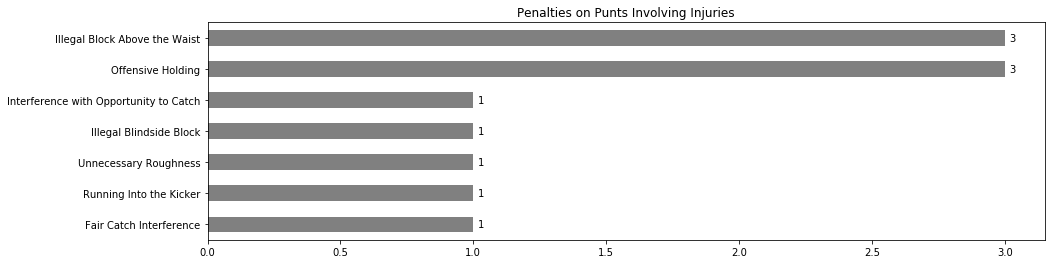

In [6]:
injury_plays = pd.merge(pi, vr)

ax = injury_plays[penalties_list].sum().loc[(injury_plays[penalties_list].sum() != 0)] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 4), color='grey', title='Penalties on Punts Involving Injuries')

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

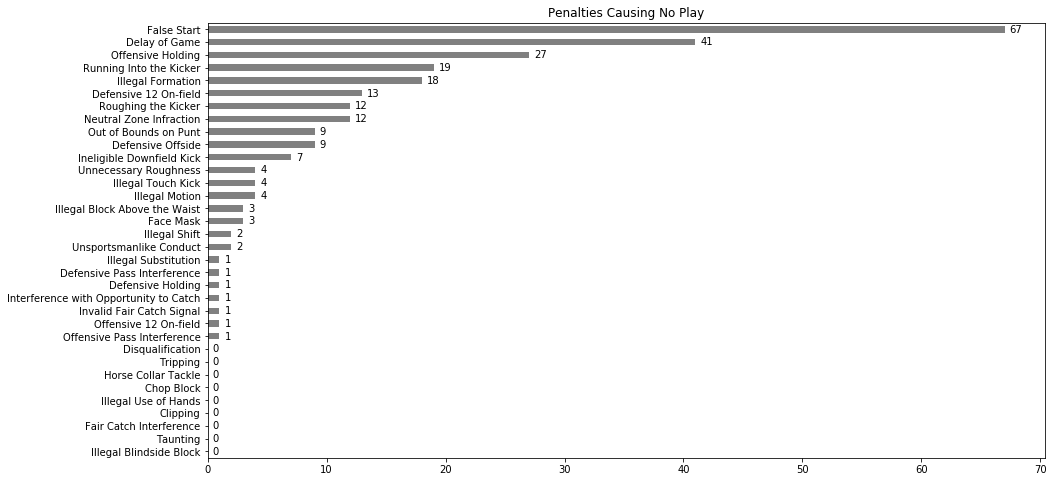

In [7]:
pi['No Play'] = pi['playdescription'].str.contains('No Play')
ax = pi[pi['No Play']][penalties_list].sum() \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 8), color='grey', title='Penalties Causing No Play')
rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
                                    # positive and negative values.

plt.show()

In [8]:
pi['challenged'] = pi['playdescription'].str.contains('challenged')
pi['review'] = pi['playdescription'].str.contains('review')
pi['Upheld'] = pi['playdescription'].str.contains('Upheld')
pi['REVERSED'] = pi['playdescription'].str.contains('REVERSED')

pi[pi['challenged'] | pi['review']] \
    .groupby(['challenged'])[['Upheld','REVERSED']] \
    .sum() \
    .sort_values('challenged', ascending=False)

,Upheld,REVERSED
challenged,,
True,11.0,12.0
False,14.0,4.0


In [18]:
pi['Reversed'] = pi['playdescription'].str.contains('REVERSED')
pi['Out of Bounds'] = pi['playdescription'].str.contains('out of bounds')
pi['Touchback'] = pi['playdescription'].str.contains('Touchback')
pi['Fair Catch'] = pi['playdescription'].str.contains('fair catch')
pi['Muffed'] = pi['playdescription'].str.contains('MUFF')
pi['Downed'] = pi['playdescription'].str.contains('downed')
pi['Punt Blocked'] = pi['playdescription'].str.contains('BLOCKED')
pi['Touchdown'] = pi['playdescription'].str.contains('TOUCHDOWN')
pi['Returned for No Gain'] = pi['playdescription'].str.contains('no gain')
pi['Fumbled'] = pi['playdescription'].str.contains('FUMBLES')
pi['Pass Incomplete'] = pi['playdescription'].str.contains('pass incomplete')

pi['Returned'] = (~pi['No Play'] &
                    ~pi['Out of Bounds'] &
                    ~pi['Touchback'] &
                    ~pi['Fair Catch'] &
                    ~pi['Downed'] &
                    ~pi['Muffed'] &
                    ~pi['Punt Blocked'] &
                    ~pi['Returned for No Gain'] &
                    ~pi['Pass Incomplete'])

# Extract the number of yards the return was for from the play description
pi['Returned For'] = pi[~pi['No Play'] &
                    ~pi['Out of Bounds'] &
                    ~pi['Touchback'] &
                    ~pi['Fair Catch'] &
                    ~pi['Downed'] &
                    ~pi['Muffed'] &
                    ~pi['Punt Blocked'] &
                    ~pi['Returned for No Gain'] &
                        ~pi['Pass Incomplete']]['playdescription'] \
    .str.extract('(for .* yard)', expand=True).fillna(False)

# Cleanup ugly retrun yards and get int
pi['return_yards'] = pi['Returned For'].replace('for -2 yards. Lateral to C.Patterson to MIN 31 for 9 yards (W.Woodyard', 'for 9 yards') \
    .replace('for -4 yards. Lateral to R.Mostert to SEA 35 for 33 yard', 'for 33 yard') \
    .replace('for 10 yards (K.Byard', 'for 11 yard') \
    .replace('for 12 yards (A.Blake; W.Woodyard','for 12 yard') \
    .replace('for 14 yards (N.Palmer; K.Byard','for 14 yard') \
    .replace('for 44 yards (R.Blanton; C.Schmidt). Buffalo challenged the runner was in bounds ruling, and the play was REVERSED. C.Schmidt punts 35 yards to SEA 38, Center-G.Sanborn. T.Lockett ran ob at BUF 40 for 22 yard', 'for 22 yard') \
    .replace('for 2 yards (W.Woodyard','for 2 yard') \
    .replace('for -2 yards. Lateral to C.Patterson to MIN 31 for 9 yard','for 9 yard') \
    .replace('for 34 yards (C.Goodwin). Atlanta challenged the runner was in bounds ruling, and the play was REVERSED. M.Bosher punts 56 yards to NE 21, Center-J.Harris. J.Edelman ran ob at NE 47 for 26 yard', 'for 26 yard') \
    .dropna() \
    .str.replace('for ','').str.replace('yard','')
# Zero return yards for 'no gain'
pi.loc[pi['Returned for No Gain'], 'return_yards'] = 0
# pull just yards from string

# Clean up `s` from yards field
pi['return_yards'] = pi['return_yards'].str[:4].replace('s',' ').replace('s','')
pi.loc[pi['Returned for No Gain'], 'return_yards'] = 0
#pi['return_yards'] = pi.loc[~pi['return_yards'].isna() & pi['return_yards'].str.contains('s')]['return_yards'].str[:2]

In [32]:
pi['return_yards'] = pi['return_yards'].str.replace('(', '')

In [33]:
pd.to_numeric(pi['return_yards'] )

0        NaN
1        NaN
2       25.0
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        9.0
10       NaN
11      -1.0
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       1.0
18       NaN
19       NaN
20       5.0
21       NaN
22      24.0
23       4.0
24       NaN
25       NaN
26       NaN
27       8.0
28      12.0
29      16.0
        ... 
6651     NaN
6652     NaN
6653     NaN
6654    19.0
6655     NaN
6656     NaN
6657     NaN
6658     NaN
6659     NaN
6660     NaN
6661     1.0
6662     NaN
6663     NaN
6664     NaN
6665     NaN
6666     NaN
6667     NaN
6668     5.0
6669     NaN
6670     NaN
6671     NaN
6672     NaN
6673    20.0
6674     NaN
6675     NaN
6676    10.0
6677     NaN
6678     NaN
6679     NaN
6680     NaN
Name: return_yards, Length: 6681, dtype: float64